# Introduction to Data Science
## Homework 4 

Student Name: Can Cui

Student Netid: N12643845
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 Points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the features so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [1]:
np.set_printoptions(suppress=True)
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np 

def cleanBosonData(infile_name):
    # Convert the feature Label to numeric (choose the minority class to be equal to 1)
    data = pd.read_csv(infile_name)
    le = LabelEncoder()
    le.fit(data["Label"])
    data["Label"] = le.transform(data["Label"])
    data.rename(columns = {'Label': 'Y'}, inplace=True)
    
    # If a feature has missing values (i.e., -999): Create a dummy variable for the missing value
    for column in data.columns:
        if min(data[column]) != -999:
            continue;
        data[column+'_mv'] = (data[column] == -999).astype(int)
        data[column] = data[column].replace(-999, np.nan)
        
    col = data.columns
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    imputer = imputer.fit(data)
    data = imputer.transform(data)
    data_clean = pd.DataFrame(data, columns = col)
    
    # After the above is done, rescales the features so that each feature has zero mean and unit variance
    col_X = [col for col in data_clean.columns if col != 'Y']
    data_clean[col_X] = StandardScaler().fit_transform(data_clean[col_X].values)
    df = pd.DataFrame(StandardScaler().fit_transform(data_clean[col_X].values), columns=col_X)
    return data_clean

### Part 2: Basic evaluations (5 Points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) by using the function defined above, and use them as training and testing data sets.

In [2]:
#Student put code here
data_train = cleanBosonData('boson_training_cut_2000.csv')
data_test = cleanBosonData('boson_testing_cut.csv')


def split_label(train, test, label):
    y_train = train[label]
    X_train = train.drop(label, axis = 1)
    y_test = test[label]
    X_test = test.drop(label, axis = 1)
    return X_train, y_train, X_test, y_test

2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

/Users/elaine/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


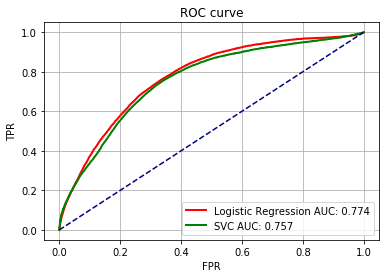

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.svm import SVC

X_train, y_train, X_test, y_test = split_label(data_train, data_test, 'Y')

log_cl = LogisticRegression(C=1e30)
log_cl.fit(X_train, y_train.ravel())

svc_cl = SVC(kernel="linear", probability=True)
svc_cl.fit(X_train, y_train.ravel())

logs_fpr, logs_tpr,_=roc_curve(y_test, log_cl.decision_function(X_test))
svc_fpr, svc_tpr,_=roc_curve(y_test,svc_cl.decision_function(X_test))

logs_auc = roc_auc_score(y_test,log_cl.predict_proba(X_test)[:,1])
svc_auc = roc_auc_score(y_test,svc_cl.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(logs_fpr, logs_tpr, color='red',
lw=2, label='Logistic Regression AUC: '+ str(round(logs_auc,3)))

plt.plot(svc_fpr, svc_tpr, color='green', lw=2, label='SVC AUC: '+ str(round(svc_auc,3)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.autoscale(enable=True)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.grid(True)
plt.legend()
plt.show()


In [8]:
import scipy

log_cl.decision_function(X_test)
scipy.stats.describe(svc_cl.decision_function(X_test))

DescribeResult(nobs=50000, minmax=(-10.728321431091572, 6.643947939319923), mean=-0.8030482220790466, variance=0.5039872620034656, skewness=1.3398286279773242, kurtosis=7.934905868189597)

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

Answer here!

Answer:
Logistic Regression has highest AUC score and occupies the more upper left corner of the ROC curve for the most of times, thus, in general Logistic Regression behaves better than SVC. However, there are thresholds that we want to only tolerate the FPR lower than 0.06 or TPR higher than 0.99, in those two special cases, we should choose SVC over Logisitic Regression. 

### Part 3: Model selection with cross-validation (7 Points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 2000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Use sklearn.model_selection.KFold to map each instance to a fold
- Performs two loops
  - Outer Loop: `for each fold in range(k)`:
    - Splits the data into `cv_train` & `cv_validate` according to previously defined fold mappings
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc_c_1,auc_c_2,..auc_c_k]` (i.e., for each c, we want a list full of auc's from each fold)

Note: Use Sklearn's KFold method, but do not use any other cross-validation convenience function. The goal is to learn how to implement the algorithm yourself!

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [123]:
#Don't forget to import any relevant libraries (i.e., sklearn.cross_validation)
from sklearn.model_selection import KFold

def xValSVM(dataset, label_name, k, cs):
    aucs = {}
    for c in cs:
        aucs[c] = []
    y = dataset[label_name]
    X = dataset.drop([label_name], axis = 1)
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(dataset):
        cv_train = X.iloc[train_index]
        cv_validate = X.iloc[test_index]
        cv_train_label = y.iloc[train_index]
        cv_validate_label = y.iloc[test_index]
        for c in cs:
            svc_cl = SVC(kernel="linear", C = c, probability = True)
            svc_cl.fit(cv_train, cv_train_label.ravel())
            AUC_c_k= roc_auc_score(cv_validate_label,svc_cl.predict_proba(cv_validate)[:,1])
            aucs[c].append(AUC_c_k)
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1, inclusive).
2.	Call aucs = xValSVM(data_train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) (don't forget, standard error of the mean of X is sqrt(Var(X)/N)
4.	Compute the value for max_1std = (mean(AUC)-StdErr(AUC)) associated with the c having max(mean(AUC)). I.e., part of what we have been calling the '1 standard error rule'.
5.	Generate a plot with the following:
    -	Log10(c) on the x-axis
    -	1 series with mean(AUC) for each c
    -	1 series with mean(AUC)-2*stderr(AUC) for each c (use ‘k+’ as color pattern)
    -	1 series with mean(AUC)+2*stderr(AUC) for each c (use ‘k--‘ as color pattern)
    -	a reference line for max_1std (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

Answer: No. When C = 10 in the the 10-fold model reach the highest average score of `0.748` (lower bound of 2 std_err of `0.731` and upper of `0.764`) which is still lower than the previous one `0.757` and logististic regression of `0.774`


In [124]:
cs = [10**i for i in range(-8,2)]
aucs = xValSVM(data_train, 'Y', 10, cs)

In [125]:
def stderr(value):
    return np.sqrt(np.var(value)/len(value))
x_axis = []
y_mean = []
y_mean_stder = []
y_mean_stder_ = []
max_1std = []

for key, value in aucs.items():
    x_axis.append(key)
    y_mean.append(np.mean(value))
    y_mean_stder.append(np.mean(value) - 2*stderr(value))
    y_mean_stder_.append(np.mean(value) + 2*stderr(value))
    max_1std.append(np.mean(value) - stderr(value))

y_max_1std = max_1std[np.argmax(y_mean)]
y_max_1std = [y_max_1std for i in range(len(x_axis))]

log_x_axis = np.log10(x_axis)

<Figure size 432x288 with 0 Axes>

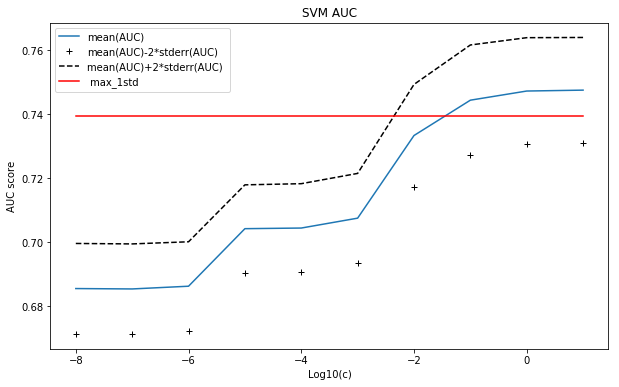

In [126]:
plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(log_x_axis, y_mean, label = 'mean(AUC)')
plt.plot(log_x_axis, y_mean_stder, 'k+', label ='mean(AUC)-2*stderr(AUC)' )
plt.plot(log_x_axis, y_mean_stder_,'k--', label = 'mean(AUC)+2*stderr(AUC) ')
plt.plot( log_x_axis, y_max_1std, color='r', label = ' max_1std')
plt.xlabel('Log10(c)')
plt.ylabel('AUC score')
plt.title('SVM AUC')
plt.legend()
plt.show()

In [127]:
print(x_axis[np.argmax(y_mean)], 
y_mean[np.argmax(y_mean)], 
y_mean_stder[np.argmax(y_mean)],
y_mean_stder_[np.argmax(y_mean)])

10 0.747537374443216 0.7310771330088426 0.7639976158775894


### Part 4: Learning Curve with Bootstrapping (8 Points)

In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.

An example of using bootstrapping to build a learning curve can be found here: https://github.com/briandalessandro/DataScienceCourse/blob/master/ipython/python35/Lecture_ERM_LogReg_3.ipynb


1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). 
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Deviation(AUC) across all bootstrap samples. Note: the standard error of the mean AUC is really the standard deviation of the bootstrapped distribution, so just use np.sqrt(np.var(...))


In [128]:
def lr_auc(y_train, X_train, y_test, X_test, parameter = None):
    log_cl = LogisticRegression(solver = 'lbfgs')
    log_cl.fit(X_train, y_train.ravel())
    return roc_auc_score(y_test, log_cl.predict_proba(X_test)[:, 1])

def svm(y_train, X_train, y_test, X_test, cs):
    for c in cs:            
        svc_cl = SVC(kernel="linear", C=c, probability = True)
        svc_cl.fit(X_train, y_train.ravel())
        AUC_c_k= roc_auc_score(y_test,svc_cl.predict_proba(X_test)[:,1])
    return AUC_c_k

def mean(AUC):
    return np.mean(AUC)

def std(AUC):
    return np.std(AUC)

In [129]:
def modBootstrapper(train, test, label, nruns, sampsize, lr=None, cs=None):
    y_test = test[label]
    X_test = test.drop(label, axis = 1)
    aucs = []
    for i in range(nruns):
        train_samp = train.loc[np.random.randint(0, len(train), size=sampsize)]
        y_train = train_samp[label]
        X_train = train_samp.drop(label, axis = 1)
        if lr:
            res = lr_auc(y_train, X_train, y_test, X_test)
            aucs.append(res)
        elif cs:
            res = svm(y_train, X_train, y_test, X_test, cs)
            aucs.append(res)
            
    return mean(aucs), std(aucs)

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs). For SVM, use the value of C identified using the 1 standard error method from part 3. For LR, use the default C.

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-2*stddev(AUC) (note: standard deviation, not standard error) for each samp size (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+2*stddev(AUC) (note: standard deviation, not standard error) for each samp size (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


In [130]:
def boot_strap_result(samplesizes, cs, rl= None, svm = None):
    x_axis = []
    y_mean = []
    y_mean_stddv = []
    y_mean_stddv_ = []

    for samplesize in samplesizes:
        if rl:
            mean_res, std_res= modBootstrapper(data_train, data_test, 'Y', 20, samplesize, True, None)
        elif svm:
            mean_res, std_res= modBootstrapper(data_train, data_test, 'Y', 20, samplesize, None, cs)
        x_axis.append(samplesize)
        y_mean.append(mean_res)
        y_mean_stddv.append(mean_res - 2*std_res)
        y_mean_stddv_.append(mean_res + 2*std_res)
        
    x_axis = np.log2(x_axis)
    if rl:
        clor = 'g'
        tag = 'rl'
    elif svm:
        clor = 'r'
        tag = 'svm'
    plt.plot(x_axis, y_mean, label = tag + ' - mean(AUC)', color = clor)
    plt.plot(x_axis, y_mean_stddv, '+', label ='mean(AUC)-2*stdev(AUC)', color = clor)
    plt.plot(x_axis, y_mean_stddv_,'--', label = 'mean(AUC)+2*stdev(AUC) ', color = clor)


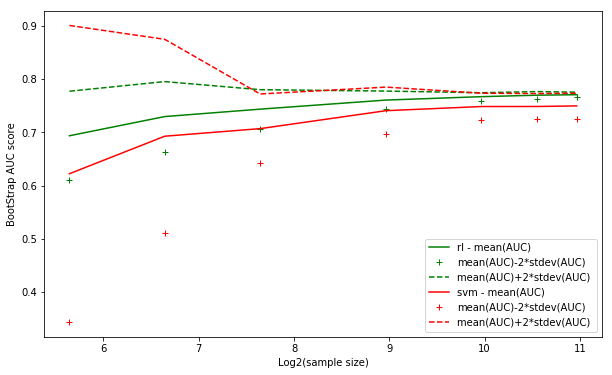

In [132]:
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]
cs = [10]
fig = plt.figure(figsize=(10, 6))
boot_strap_result(samplesizes, cs, True)
boot_strap_result(samplesizes, cs, None, cs)
plt.xlabel('Log2(sample size)')
plt.ylabel('BootStrap AUC score')
plt.legend()
plt.show()

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


Answer here:
Logistic Regression are more suitable for the smaller sample sizes. 
I don't think it's worth the investment to aquire more data since the sample size reaches 500 there's no significant jump on the model performance, thus we might assume that there's not so much in the increase of performance from dataset size 1024 to 2048. 

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?



Answer here: when the sample size is small, from the chart above we can see that for both the Logistic Regression Model and SVM model that AUC score is much lower and standard deviation is larger than those when datasize is large. Thus, cross-validation is biased. When the dataset size is 500, it performs the same as the data size of 1024. However, with a training dataset of 60, the model performance is worse and this would result in a considerable overestimate of prediction error (since standard deviation is large). Hence as an estimate of Err, cross-validation would be biased upward